<a href="https://colab.research.google.com/github/MGyuyu/ADE-PINN-Masters-Thesis-Code/blob/main/PINN/PINN_1D_ADE_Forward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install pyDOE

In [17]:
#@title Imports forward
import sys
import os
import time
from datetime import datetime
import tensorflow as tf
import numpy as np
import scipy.io
import tensorflow_probability as tfp
from pyDOE import lhs

import matplotlib
from scipy.io import savemat
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

In [51]:
#@title Prep data forward
def prep_data(path, N_u=None, N_f=None, ub=None, lb=None, noise=0.0):
    # Reading external data
    data = scipy.io.loadmat(path)

    # Flatten makes [[]] into [], [:,None] makes it a column vector
    t = data['t'].flatten()[:,None] # T x 1
    x = data['x'].flatten()[:,None] # N x 1

    # Keeping the 2D data for the solution data (real() is maybe to make it float by default, in case of zeroes)
    Exact_u = np.real(data['u']) # T x N

    # Meshing x and t in 2D (100,100)
    X, T = np.meshgrid(x,t)

    # Preparing the inputs x and t (meshed as X, T) for predictions in one single array, as X_star
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

    # Preparing the testing u_star
    #u_star = np.swapaxes(Exact_u,0,1)
    u_star = Exact_u.flatten()[:,None]

    # Domain bounds (lowerbounds upperbounds) [x, t]
    lb = X_star.min(axis=0)
    ub = X_star.max(axis=0)
    # Getting the initial conditions (t=0)
    xx1 = np.hstack((X[0:1,:].flatten()[:,None], T[0:1,:].flatten()[:,None]))
    uu1 = Exact_u[0:1,:].flatten()[:,None]
    # Getting the lowest boundary conditions (x=-1)
    xx2 = np.hstack((X[:,0:1].flatten()[:,None], T[:,0:1].flatten()[:,None]))
    uu2 = Exact_u[:,0:1].flatten()[:,None]
    # Getting the highest boundary conditions (x=1)
    xx3 = np.hstack((X[:,-1:].flatten()[:,None], T[:,-1:].flatten()[:,None]))
    uu3 = Exact_u[:,-1:].flatten()[:,None]
    # Stacking them in multidimensional tensors for training (X_u_train is for now the continuous boundaries)
    X_u_train = np.vstack([xx1, xx2, xx3])
    u_train = np.vstack([uu1, uu2, uu3])

    # Generating the x and t collocation points for f, with each having a N_f size
    # We pointwise add and multiply to spread the LHS over the 3D domain
    X_f_train = lb + (ub-lb)*lhs(2, N_f)

    # Generating a uniform random sample from ints between 0, and the size of x_u_train, of size N_u (initial data size) and without replacement (unique)
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)

    # Getting the corresponding X_u_train (which is now scarce boundary/initial coordinates)
    X_u_train = X_u_train[idx,:]
    # Getting the corresponding u_train
    u_train = u_train[idx,:]

    # Noise
    u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
    u_star = u_star + noise*np.std(u_star)*np.random.randn(u_star.shape[0], u_star.shape[1])

    return x, t, X, T, X_star, u_star, X_u_train, u_train, X_f_train, ub, lb

In [34]:
#@title Discrete plotter
def DiscretePlotter(x,t,u_plot,u_star_plot,lb,ub):

    def figsize(scale, nplots = 1):
        fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
        inches_per_pt = 1.0/72.27                       # Convert pt to inch
        golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
        fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
        fig_height = nplots*fig_width*golden_mean              # height in inches
        fig_size = [fig_width,fig_height]
        return fig_size

    # I make my own newfig and savefig functions
    def newfig(width, nplots = 1):
        fig = plt.figure(figsize=figsize(width, nplots))
        ax = fig.add_subplot(111)
        return fig, ax

    N_t = t.shape[0]
    Lt = ub[1] - lb[1]
    t0 = 0; t1 = Lt/5; t2 = 2*Lt/5; t3 = 3*Lt/5; t4 = 4*Lt/5; t5 = 5*Lt/5;
    N0 = int(np.ceil((t0*N_t)/Lt))
    N1 = int(np.ceil((t1*N_t)/Lt))
    N2 = int(np.ceil((t2*N_t)/Lt))
    N3 = int(np.ceil((t3*N_t)/Lt))
    N4 = int(np.ceil((t4*N_t)/Lt))
    N5 = int(np.floor((t5*N_t-1)/Lt))

    fig, ax = newfig(3.0, 3.0)
    gs1 = gridspec.GridSpec(2, 3)
    gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,u_star_plot[:,N0], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,u_plot[:,N0], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.set_title('$t = 0.0$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,u_star_plot[:,N1], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,u_plot[:,N1], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.set_title('$t = 0.4$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,u_star_plot[:,N2], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,u_plot[:,N2], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.set_title('$t = 0.8$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[1, 0])
    ax.plot(x,u_star_plot[:,N3], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,u_plot[:,N3], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.set_title('$t = 1.2$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[1, 1])
    ax.plot(x,u_star_plot[:,N4], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,u_plot[:,N4], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.set_title('$t = 1.6$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[1, 2])
    ax.plot(x,u_star_plot[:,N5], 'b-', linewidth = 2, label = 'Exact')
    ax.plot(x,u_plot[:,N5], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.set_title('$t = 2.0$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    plt.show()

In [52]:
#@title Extract data from PINN
def ExtractData(pinn, X_star, X_u_train, u_star):

  # Getting the model predictions, over dense (x,y,t) domain
  X_star_batches = np.array_split(X_star,100)
  u_pred, _ = pinn.predict(X_star_batches[0])
  for i in range(len(X_star_batches)-1):
    u_pred_batch, _ = pinn.predict(X_star_batches[i+1])
    u_pred = np.vstack((u_pred,u_pred_batch))

  # Getting the model prediction, over training (x,y,t)
  X_u_train_batches = np.array_split(X_u_train,100)
  u_train_pred, _ = pinn.predict(X_u_train_batches[0])
  for i in range(len(X_u_train_batches)-1):
    u_train_batch, _ = pinn.predict(X_u_train_batches[i+1])
    u_train_pred = np.vstack((u_train_pred,u_train_batch))

  u_train_pred = u_train_pred.flatten()[:,None]

  N_x = x.shape[0]
  N_t = t.shape[0]

  #X_plot = X_star.reshape(N_t,N_x,2).T
  u_plot = u_pred.reshape(N_t,N_x).T
  u_star_plot = u_star.reshape(N_t,N_x).T
  #X_test = X_plot[:,:,0]


  trained_weights = pinn.get_weights()

  return u_star_plot, u_plot, u_train_pred, trained_weights

In [53]:
#@title Training data plotter forward
def TrainingDataPlotterForward(X_u_train, X_f, ub, lb):

    fig = plt.figure()
    ax = fig.add_subplot()

    ax.scatter(X_f[:,1],X_f[:,0], s=4.0, marker='x')
    ax.scatter(X_u_train[:,1],X_u_train[:,0], s=4.0, marker='o', alpha=1.0)

    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_xlim(lb[1]-0.1, ub[1]+0.1)
    ax.set_ylim(lb[0]-0.1, ub[0]+0.1)

    plt.show()

    print('Amount of training data: ' + str(X_u_train.shape[0] + X_f.shape[0]))

In [54]:
#@title Logger class
class Logger(object):
    def __init__(self, frequency=10):
        print("TensorFlow version: {}".format(tf.__version__))
        print("Eager execution: {}".format(tf.executing_eagerly()))
        print("GPU-accerelated: {}".format(tf.test.is_gpu_available()))

        self.start_time = time.time()
        self.frequency = frequency

    def __get_elapsed(self):
        return datetime.fromtimestamp(time.time() - self.start_time).strftime("%H:%M:%S")

    def __get_error_u(self):
        return self.error_fn()

    def set_error_fn(self, error_fn):
        self.error_fn = error_fn

    def log_train_start(self, model):
        print("\nTraining started")
        print("================")
        self.model = model
        print(self.model.summary())

    def log_train_epoch(self, epoch, loss, current_best_loss, custom=""):
        if epoch % self.frequency == 0:
            print(f"{'tf_epoch'} = {epoch:6d}  elapsed = {self.__get_elapsed()}  loss = {loss:.4e}  best loss = {current_best_loss:.4e}  error = {self.__get_error_u():.4e}  " + custom)

    def log_train_opt(self, name):
        print(f"—— Starting {name} optimization ——")

    def log_train_end(self, epoch, loss, current_best_loss, custom=""):
        print("==================")
        print(f"Training finished (epoch {epoch}): duration = {self.__get_elapsed()}  loss = {loss:.4e}  best loss = {current_best_loss:.4e}  error = {self.__get_error_u():.4e}  " + custom)
        print('Applying the weights at the best epoch to the model...')
        return self.__get_elapsed()

In [55]:
#@title Loss and parameter plotter
def LossParameterPlotterForward(loss_history):
    plt.figure(figsize=(18,6))
    plt.suptitle('Training Metrics')

    plt.ylabel("Loss", fontsize=14)
    plt.xlabel("Epoch", fontsize=14)
    plt.semilogy(loss_history)

    plt.show()

In [56]:
#@title LBFGS v2
def dot(a, b):
  """Dot product function since TensorFlow doesn't have one."""
  return tf.reduce_sum(a*b)

def verbose_func(s):
  print(s)

final_loss = None
times = []
def lbfgs(opfunc, x, state, maxIter = 100, learningRate = 1, do_verbose = True):
  """port of lbfgs.lua, using TensorFlow eager mode.
  """

  global final_loss, times

  maxEval = maxIter*1.25
  tolFun = 1e-5
  tolX = 1e-9
  nCorrection = 50
  isverbose = False

  # verbose function
  if isverbose:
    verbose = verbose_func
  else:
    verbose = lambda x: None

  f, g = opfunc(x)

  f_hist = [f]
  currentFuncEval = 1
  state.funcEval = state.funcEval + 1
  p = g.shape[0]

  # check optimality of initial point
  tmp1 = tf.abs(g)
  if tf.reduce_sum(tmp1) <= tolFun:
    verbose("optimality condition below tolFun")
    return x, f_hist

  # optimize for a max of maxIter iterations
  nIter = 0
  times = []
  while nIter < maxIter:
    start_time = time.time()

    # keep track of nb of iterations
    nIter = nIter + 1
    state.nIter = state.nIter + 1

    ############################################################
    ## compute gradient descent direction
    ############################################################
    if state.nIter == 1:
      d = -g
      old_dirs = []
      old_stps = []
      Hdiag = 1
    else:
      # do lbfgs update (update memory)
      y = g - g_old
      s = d*t
      ys = dot(y, s)

      if ys > 1e-10:
        # updating memory
        if len(old_dirs) == nCorrection:
          # shift history by one (limited-memory)
          del old_dirs[0]
          del old_stps[0]

        # store new direction/step
        old_dirs.append(s)
        old_stps.append(y)

        # update scale of initial Hessian approximation
        Hdiag = ys/dot(y, y)

      # compute the approximate (L-BFGS) inverse Hessian
      # multiplied by the gradient
      k = len(old_dirs)

      # need to be accessed element-by-element, so don't re-type tensor:
      ro = [0]*nCorrection
      for i in range(k):
        ro[i] = 1/dot(old_stps[i], old_dirs[i])


      # iteration in L-BFGS loop collapsed to use just one buffer
      # need to be accessed element-by-element, so don't re-type tensor:
      al = [0]*nCorrection

      q = -g
      for i in range(k-1, -1, -1):
        al[i] = dot(old_dirs[i], q) * ro[i]
        q = q - al[i]*old_stps[i]

      # multiply by initial Hessian
      r = q*Hdiag
      for i in range(k):
        be_i = dot(old_stps[i], r) * ro[i]
        r += (al[i]-be_i)*old_dirs[i]

      d = r
      # final direction is in r/d (same object)

    g_old = g
    f_old = f

    ############################################################
    ## compute step length
    ############################################################
    # directional derivative
    gtd = dot(g, d)

    # check that progress can be made along that direction
    if gtd > -tolX:
      verbose("Can not make progress along direction.")
      break

    # reset initial guess for step size
    if state.nIter == 1:
      tmp1 = tf.abs(g)
      t = min(1, 1/tf.reduce_sum(tmp1))
    else:
      t = learningRate



    x += t*d

    if nIter != maxIter:
    # re-evaluate function only if not in last iteration
    # the reason we do this: in a stochastic setting,
    # no use to re-evaluate that function here
      f, g = opfunc(x)

    lsFuncEval = 1
    f_hist.append(f)


    # update func eval
    currentFuncEval = currentFuncEval + lsFuncEval
    state.funcEval = state.funcEval + lsFuncEval

    ############################################################
    ## check conditions
    ############################################################
    if nIter == maxIter:
      break

    if currentFuncEval >= maxEval:
      # max nb of function evals
      print('max nb of function evals')
      break

    tmp1 = tf.abs(g)
    if tf.reduce_sum(tmp1) <=tolFun:
      # check optimality
      print('optimality condition below tolFun')
      break

    tmp1 = tf.abs(d*t)
    if tf.reduce_sum(tmp1) <= tolX:
      # step size below tolX
      print('step size below tolX')
      break

    if tf.abs(f,f_old) < tolX:
      # function value changing less than tolX
      print('function value changing less than tolX'+str(tf.abs(f-f_old)))
      break

    if do_verbose:
      if nIter % 10 == 0:
        print("Step %3d loss %6.5f "%(nIter, f.numpy()))


    if nIter == maxIter - 1:
      final_loss = f.numpy()


  # save state
  state.old_dirs = old_dirs
  state.old_stps = old_stps
  state.Hdiag = Hdiag
  state.g_old = g_old
  state.f_old = f_old
  state.t = t
  state.d = d

  return x, f_hist, currentFuncEval

# dummy/Struct gives Lua-like struct object with 0 defaults
class dummy(object):
  pass

class Struct(dummy):
  def __getattribute__(self, key):
    if key == '__dict__':
      return super(dummy, self).__getattribute__('__dict__')
    return self.__dict__.get(key, 0)


In [57]:
#@title PINN forward w/ Adaptive weights (Adaptive Weighting disabled)
class PhysicsInformedNN(object):
    def __init__(self, layers, optimizer, logger, ub, lb, f_param, u_param, activation_func=tf.keras.activations.tanh):
        # Descriptive Keras model [2, 20, …, 20, 1]
        self.u_model = tf.keras.Sequential()
        self.u_model.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
        self.u_model.add(tf.keras.layers.Lambda(
          lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
        for width in layers[1:-1]:
            self.u_model.add(tf.keras.layers.Dense(
              width, activation=activation_func,
              kernel_initializer='glorot_normal'))
        self.u_model.add(tf.keras.layers.Dense(
              layers[-1], activation=None,
              kernel_initializer='glorot_normal'))

        self.dtype = tf.float32
        self.loss_history = []
        self.f_param = f_param
        self.u_param = u_param
        self.current_best_loss = 1e10
        self.current_best_weights = []

        # Computing the sizes of weights/biases for future decomposition
        self.sizes_w = []
        self.sizes_b = []
        for i, width in enumerate(layers):
            if i != 1:
                self.sizes_w.append(int(width * layers[1]))
                self.sizes_b.append(int(width if i != 0 else layers[1]))


        self.optimizer = optimizer
        self.logger = logger

        self.beta = 0.1 # Default 0.1
        self.adaptive_param = 1.0
        self.adaptive_param_hat = 1.0
        self.adaptive_param_history = []

    # The actual PINN
    def __f_model(self, X_f):

        # Separating the collocation coordinates
        x_f = tf.convert_to_tensor(X_f[:, 0:1], dtype=self.dtype)
        t_f = tf.convert_to_tensor(X_f[:, 1:2], dtype=self.dtype)

        # Using the new GradientTape paradigm of TF2.0,
        # which keeps track of operations to get the gradient at runtime
        with tf.GradientTape(persistent=True) as tape:
            # Watching the two inputs we’ll need later, x and t
            tape.watch(x_f)
            tape.watch(t_f)
            # Packing together the inputs
            X_f = tf.stack([x_f[:,0], t_f[:,0]], axis=1)

            # Getting the prediction
            u = self.u_model(X_f)
            # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
            u_x = tape.gradient(u, x_f)

        # Getting the other derivatives
        u_xx = tape.gradient(u_x, x_f)
        u_t = tape.gradient(u, t_f)

        # Letting the tape go
        del tape

        PDE = u_t + 1.0*u_x - (0.25/np.pi)*u_xx - 5.0*tf.exp(-100*(x_f+0.8)**2)
        # Buidling the PINNs
        return PDE

    def __loss(self, X_f, X_u, u, u_pred):
        f_pred = self.__f_model(X_f)
        loss_f = tf.reduce_mean(tf.square(f_pred))
        loss_u = tf.reduce_mean(tf.square(u - u_pred))
        return loss_u, loss_f

    def __grad(self, X_f, X_u, u):
        with tf.GradientTape() as tape:
            loss_u, loss_f = self.__loss(X_f, X_u, u, self.u_model(X_u))
            loss_value = self.adaptive_param*loss_u + 1.0*loss_f
        return loss_value, tape.gradient(loss_value, self.__wrap_training_variables())

    def __adaptive_param(self, X_f, X_u, u):
        with tf.GradientTape(persistent=True) as tape:
            loss_u, loss_f = self.__loss(X_f, X_u, u, self.u_model(X_u))
            grad_u = tape.gradient(self.adaptive_param*loss_u, self.__wrap_training_variables())
            grad_f = tape.gradient(loss_f, self.__wrap_training_variables())
        del tape

        grad_f_flatten = []
        grad_u_flatten = []
        for g in grad_f:
            grad_f_flatten.append(tf.reshape(g,[-1]))
        grad_f_flatten = tf.concat(grad_f_flatten,0)
        for g in grad_u:
            grad_u_flatten.append(tf.reshape(g,[-1]))
        grad_u_flatten = tf.concat(grad_u_flatten,0)

        max_grad_f = tf.reduce_max(tf.abs(grad_f_flatten))
        mean_grad_u = tf.reduce_mean(tf.abs(grad_u_flatten))
        self.adaptive_param_hat = max_grad_f / mean_grad_u
        self.adaptive_param = self.adaptive_param * (1.0 - self.beta) + self.beta * self.adaptive_param_hat    # As implemented in paper
        self.adaptive_param_history.append(self.adaptive_param)

    def __wrap_training_variables(self):
        var = self.u_model.trainable_variables
        return var

    def get_loss_and_flat_grad(self, X_f, X_u, u):
        def loss_and_flat_grad(w):
            with tf.GradientTape() as tape:
                self.set_weights(w)
                loss_u, loss_f = self.__loss(X_f, X_u, u, self.u_model(X_u))
                loss_value = self.adaptive_param*loss_u + 1.0*loss_f
            grad = tape.gradient(loss_value, self.__wrap_training_variables())
            grad_flat = []
            for g in grad:
                grad_flat.append(tf.reshape(g, [-1]))
            grad_flat = tf.concat(grad_flat, 0)
            return loss_value, grad_flat
        return loss_and_flat_grad

    def get_weights(self):
        w = []
        for layer in self.u_model.layers[1:]:
            weights_biases = layer.get_weights()
            weights = weights_biases[0].flatten()
            biases = weights_biases[1]
            w.extend(weights)
            w.extend(biases)
        return tf.convert_to_tensor(w, dtype=self.dtype)

    def set_weights(self, w):
        for i, layer in enumerate(self.u_model.layers[1:]):
            start_weights = sum(self.sizes_w[:i]) + sum(self.sizes_b[:i])
            end_weights = sum(self.sizes_w[:i+1]) + sum(self.sizes_b[:i])
            weights = w[start_weights:end_weights]
            w_div = int(self.sizes_w[i] / self.sizes_b[i])
            weights = tf.reshape(weights, [w_div, self.sizes_b[i]])
            biases = w[end_weights:end_weights + self.sizes_b[i]]
            weights_biases = [weights, biases]
            layer.set_weights(weights_biases)

    def summary(self):
        return self.u_model.summary()

    def mini_batch(self, X_f, X_u, u, batch_size):

        idx_u = np.random.randint(0, tf.shape(X_u).numpy()[0], batch_size)
        idx_f = np.random.randint(0, tf.shape(X_f).numpy()[0], batch_size)

        X_f_batch = tf.gather(X_f, idx_f)
        X_u_batch = tf.gather(X_u, idx_u)
        u_batch   = tf.gather(u, idx_u)

        return X_f_batch, X_u_batch, u_batch

    # The training function
    def fit(self, X_f, X_u, u, tf_epochs, batch_size=512):
        self.logger.log_train_start(self)

        # Creating the tensors
        X_u = tf.convert_to_tensor(X_u, dtype=self.dtype)
        X_f = tf.convert_to_tensor(X_f, dtype=self.dtype)
        u = tf.convert_to_tensor(u, dtype=self.dtype)

        iter_per_epoch = int((np.floor(tf.shape(X_f).numpy()[0] + np.floor(tf.shape(X_u).numpy()[0]))/batch_size))

        def log_train_epoch(epoch, loss):
            custom = f"adaptive_param = {self.adaptive_param:4f}"
            self.logger.log_train_epoch(epoch, loss, self.current_best_loss, custom)
        self.logger.log_train_opt("Adam")

        for epoch in range(tf_epochs):
            for index in range(iter_per_epoch):

                X_f_batch, X_u_batch, u_batch = self.mini_batch(X_f, X_u, u, batch_size)

                #self.__adaptive_param(X_f_batch, X_u_batch, u_batch)

                # Optimization step
                loss_value, grads = self.__grad(X_f_batch, X_u_batch, u_batch)
                self.optimizer.apply_gradients(zip(grads, self.__wrap_training_variables()))

            loss_value, _ = self.__grad(X_f, X_u, u)

            if loss_value < self.current_best_loss:
              self.current_best_loss = loss_value
              self.current_best_weights = self.get_weights()

            log_train_epoch(epoch, loss_value)

            self.loss_history.append(loss_value.numpy())

        #l-bfgs-b optimization
        print("Starting L-BFGS training")

        loss_and_flat_grad = self.get_loss_and_flat_grad(X_f, X_u, u)

        lbfgs_weights, lbfgs_history, _ = lbfgs(loss_and_flat_grad, self.get_weights(), Struct(), maxIter=500, learningRate=0.8)

        if lbfgs_history[-1] < self.current_best_loss:
            self.current_best_loss = lbfgs_history[-1]
            self.current_best_weights = lbfgs_weights

        for i in lbfgs_history:
            self.loss_history.append(i.numpy())

        self.set_weights(self.current_best_weights)
        elapsed_time = self.logger.log_train_end(tf_epochs, loss_value, self.current_best_loss)
        return self.loss_history, elapsed_time, self.adaptive_param_history

    def predict(self, X_star):
        u_star = self.u_model(X_star)
        f_star = self.__f_model(X_star)
        return u_star.numpy(), f_star.numpy()

In [58]:
#@title Error forward
def error():
    return 1.0

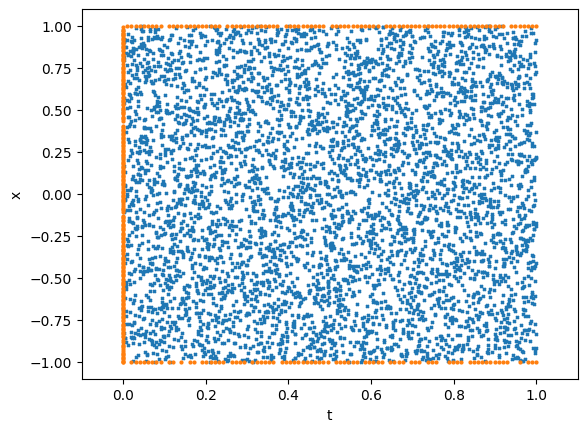

Amount of training data: 5400


In [59]:
############### USER INPUT ##################


# Data-points
N_u = 400
# Collocation-points
N_f = 5000
# FNN size
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
# Activation function
activation_func = tf.keras.activations.tanh

# ADAM
tf_epochs = 500  # Epochs w/ ADAM
tf_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
batch_size = 5400 # Full batch = N_u + N_f

f_param = 10
u_param = 0.1

# Load data
noise = 0.0

### User needs to input path location. For example: path = os.path.join("/folder/1D_ADE_Training_Data.mat") ###

path = os.path.join("1D_ADE_Training_Data.mat") #### Path to 1D Training data ####
x, t, X, T, X_star, u_star, X_u_train, u_train, X_f, ub, lb = prep_data(path, N_u, N_f, noise)

TrainingDataPlotterForward(X_u_train, X_f, ub, lb)

In [60]:
# Creating the model and training
logger = Logger(frequency=1)
logger.set_error_fn(error)
pinn = PhysicsInformedNN(layers, tf_optimizer, logger, ub, lb, f_param, u_param, activation_func)

TensorFlow version: 2.18.0
Eager execution: True
GPU-accerelated: True


In [61]:
#loss_history, elapsed_time = pinn.fit(X_f, X_u_train, u_train, tf_epochs, batch_size)
loss_history, elapsed_time, adaptive_param_history = pinn.fit(X_f, X_u_train, u_train, tf_epochs, batch_size)


Training started


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_4 (Lambda)                    │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 20)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,021 (11.80 KB)

 Trainable params: 3,021 (11.80 KB)

 Non-trainable params: 0 (0.00 B)

None
—— Starting Adam optimization ——
tf_epoch =      0  elapsed = 00:00:03  loss = 1.6878e+00  best loss = 1.6878e+00  error = 1.0000e+00  adaptive_param = 1.000000
tf_epoch =      1  elapsed = 00:00:03  loss = 1.5896e+00  best loss = 1.5896e+00  error = 1.0000e+00  adaptive_param = 1.000000
tf_epoch =      2  elapsed = 00:00:03  loss = 1.5123e+00  best loss = 1.5123e+00  error = 1.0000e+00  adaptive_param = 1.000000
tf_epoch =      3  elapsed = 00:00:04  loss = 1.4534e+00  best loss = 1.4534e+00  error = 1.0000e+00  adaptive_param = 1.000000
tf_epoch =      4  elapsed = 00:00:04  loss = 1.4102e+00  best loss = 1.4102e+00  error = 1.0000e+00  adaptive_param = 1.000000
tf_epoch =      5  elapsed = 00:00:04  loss = 1.3799e+00  best loss = 1.3799e+00  error = 1.0000e+00  adaptive_param = 1.000000
tf_epoch =      6  elapsed = 00:00:04  loss = 1.3582e+00  best loss = 1.3582e+00  error = 1.0000e+00  adaptive_param = 1.000000
tf_epoch =      7  elapsed = 00:00:05  loss = 1.3405e+00  best los

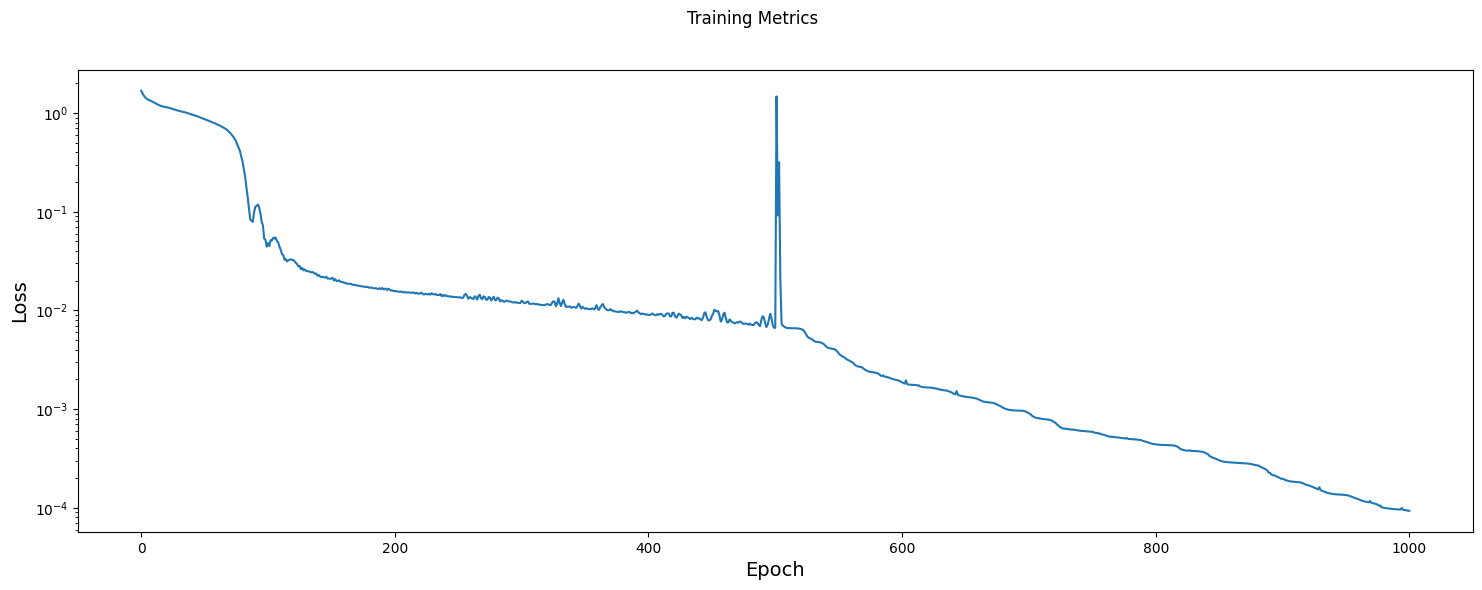

In [62]:
LossParameterPlotterForward(loss_history)

In [63]:
u_star_plot, u_plot, u_train_pred, trained_weights = ExtractData(pinn, X_star, X_u_train, u_star)

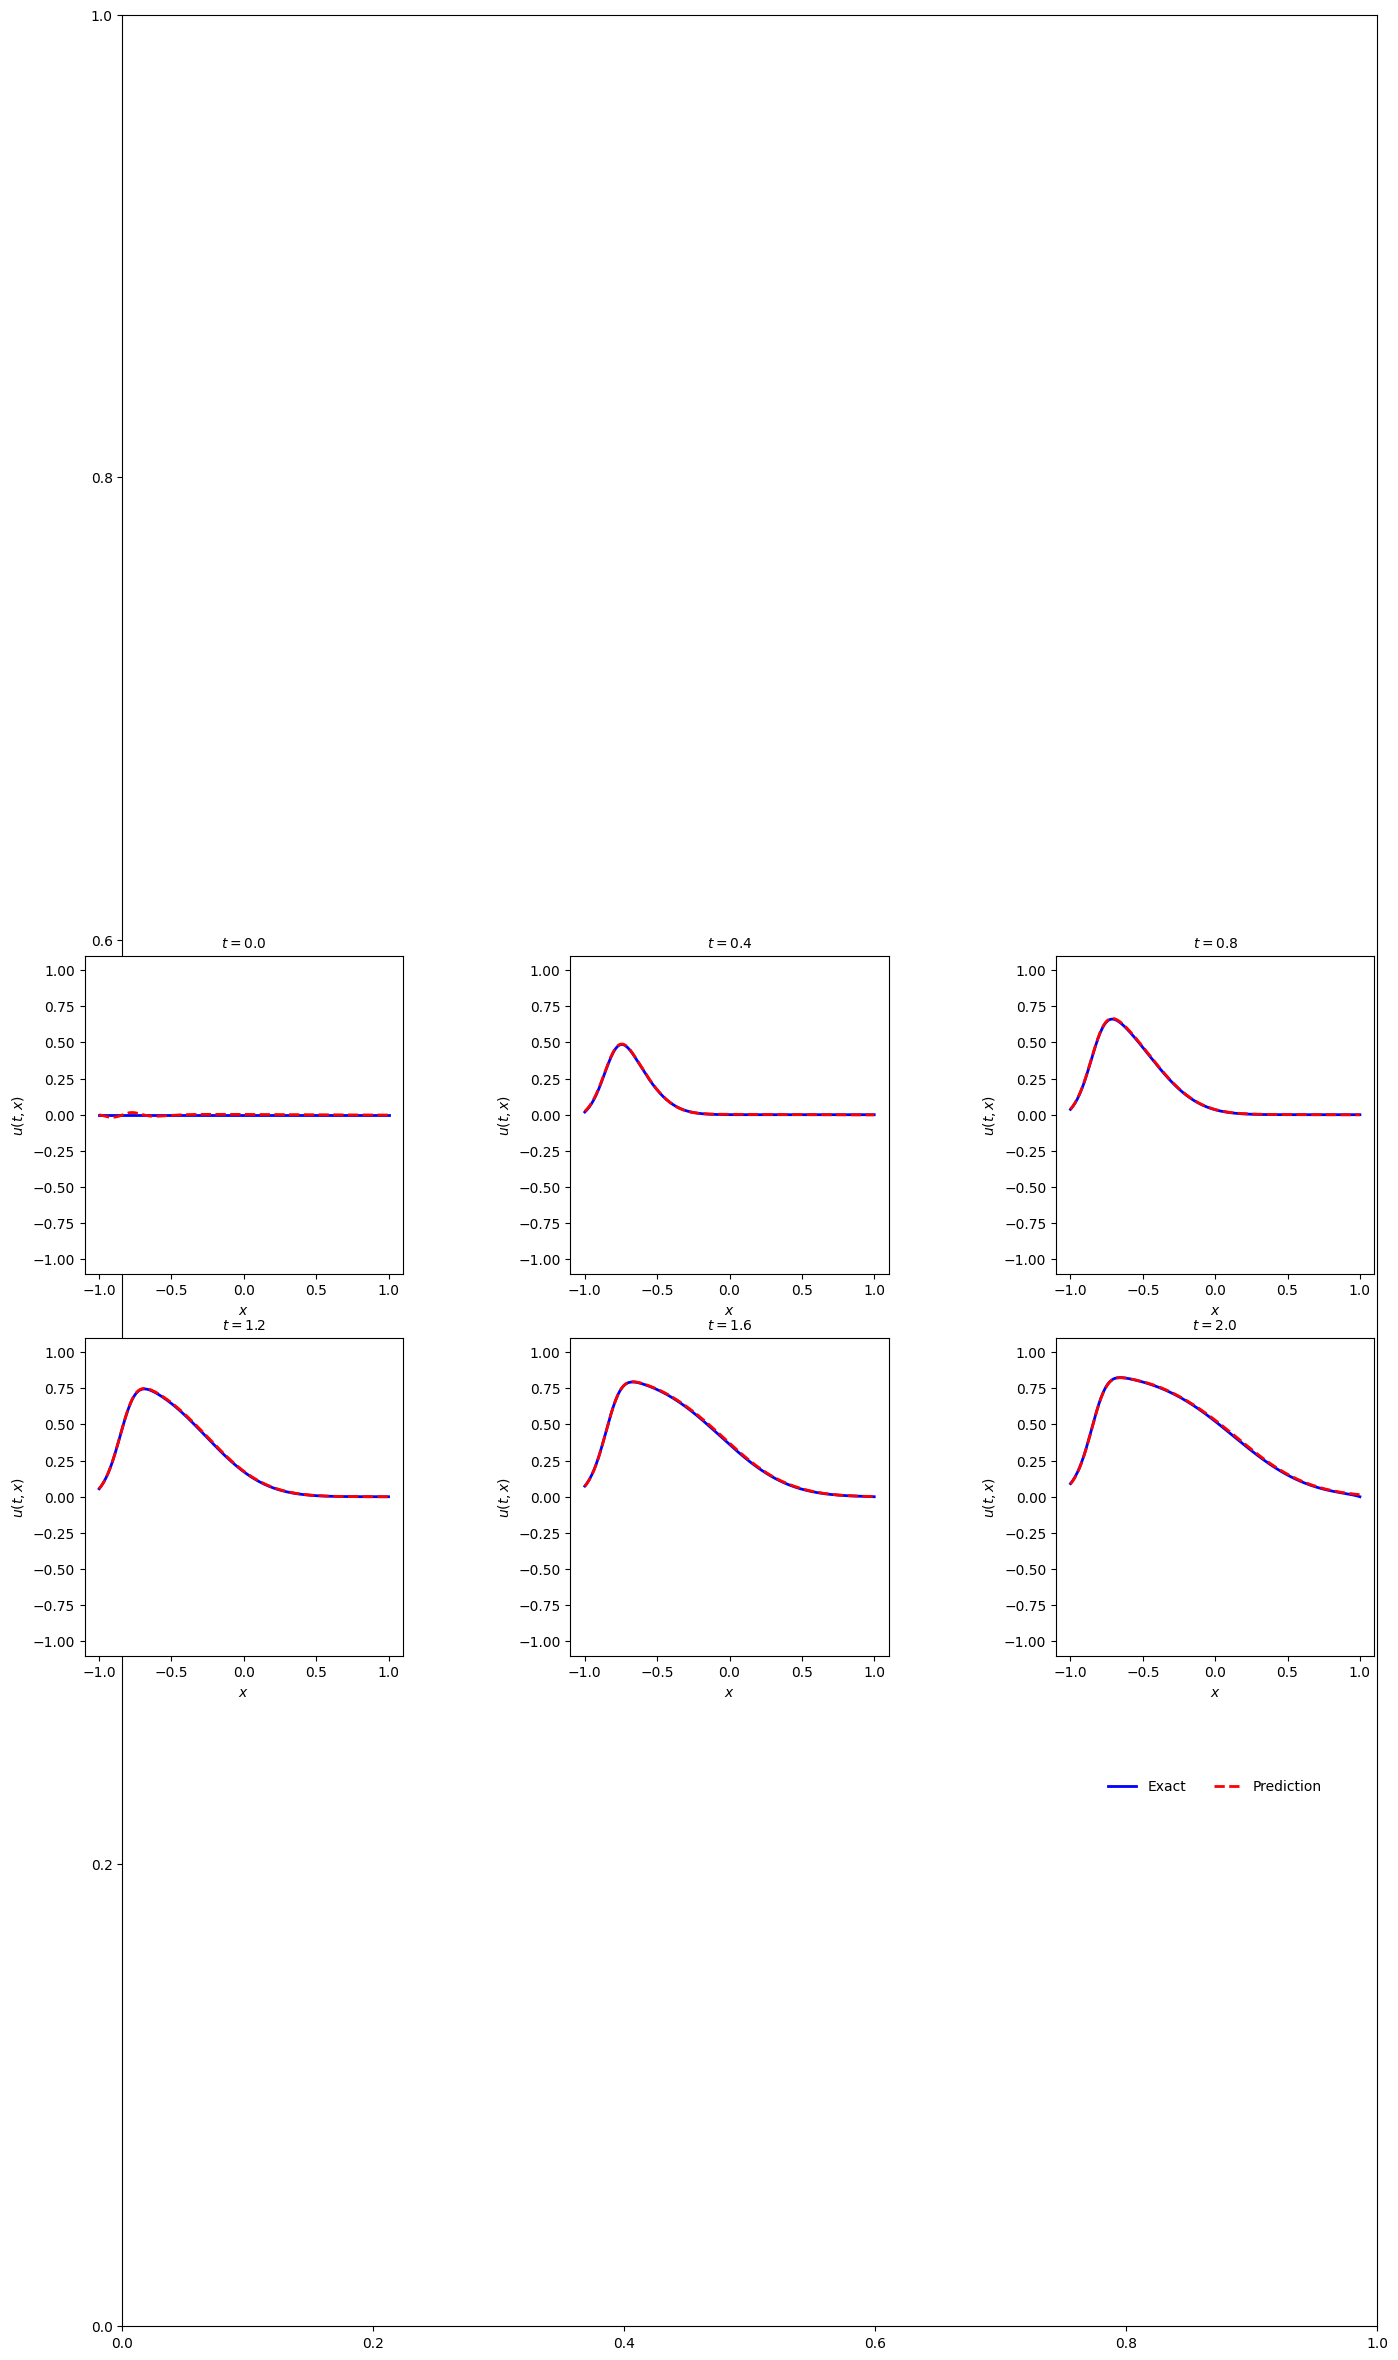

In [64]:
DiscretePlotter(x,t,u_plot,u_star_plot,lb,ub)

In [65]:
savemat('PINNresults1DForwardFullbatchLBFGS.mat', {'u_pred': u_plot, 'u_true': u_star_plot, 'loss_history': loss_history,
                          'X_u_train': X_u_train, 'u_train': u_train, 'u_train_pred': u_train_pred, 'X': X, 'T': T, 'X_star': X_star,
                          'x': x, 't': t, 'X_f': X_f, 'layers': layers, 'noise': noise, 'u_param': u_param, 'f_param': f_param})

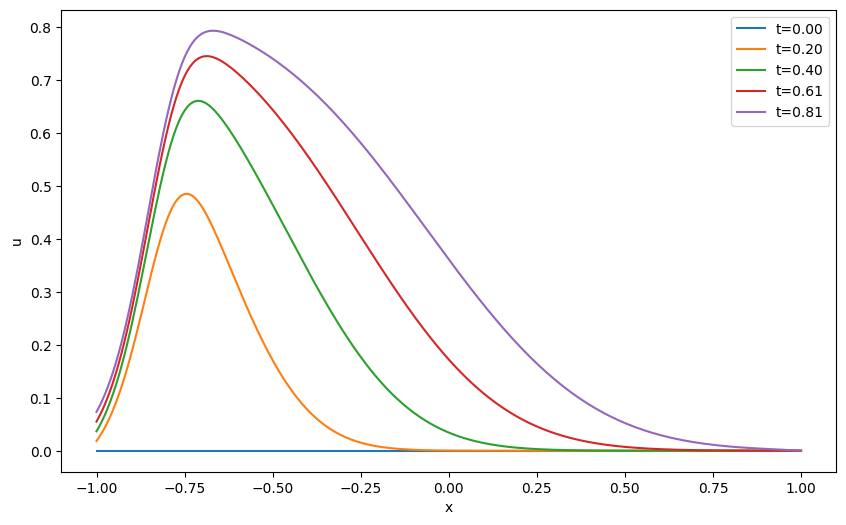

In [49]:
data = scipy.io.loadmat('1D_ADE_Training_Data.mat')
x = data['x'].flatten()
t = data['t'].flatten()
u = data['u']

# 绘制几个时间点的数据
plt.figure(figsize=(10,6))
for i in range(0, len(t), len(t)//5):
    plt.plot(x, u[i,:], label=f't={t[i]:.2f}')
plt.legend()
plt.xlabel('x')
plt.ylabel('u')
plt.show()

In [50]:
# 检查边界值
print("Left boundary (x=-1):", u[:, 0])
print("Right boundary (x=1):", u[:, -1])

Left boundary (x=-1): [0.         0.00091624 0.00183248 0.00274872 0.00366496 0.0045812
 0.00549744 0.00641368 0.00732992 0.00824616 0.0091624  0.01007864
 0.01099488 0.01191112 0.01282736 0.0137436  0.01465984 0.01557608
 0.01649232 0.01740856 0.0183248  0.01924104 0.02015728 0.02107352
 0.02198976 0.022906   0.02382224 0.02473848 0.02565472 0.02657096
 0.0274872  0.02840344 0.02931968 0.03023592 0.03115216 0.0320684
 0.03298464 0.03390088 0.03481712 0.03573336 0.0366496  0.03756584
 0.03848208 0.03939832 0.04031456 0.0412308  0.04214704 0.04306328
 0.04397952 0.04489576 0.045812   0.04672824 0.04764448 0.04856072
 0.04947696 0.0503932  0.05130944 0.05222568 0.05314192 0.05405816
 0.0549744  0.05589064 0.05680688 0.05772312 0.05863936 0.0595556
 0.06047184 0.06138808 0.06230432 0.06322056 0.0641368  0.06505304
 0.06596928 0.06688552 0.06780176 0.068718   0.06963424 0.07055048
 0.07146673 0.07238297 0.07329921 0.07421545 0.07513169 0.07604793
 0.07696417 0.07788041 0.07879665 0.0797128